In [ ]:
##########################################################
###USED FOR INTERNAL TESTING - USERS MAY SKIP THIS CELL###
##########################################################
!pip install pyarrow
from google.cloud import storage
from google.cloud import bigquery
from google.cloud.exceptions import NotFound

# Internal testers - Fill in with your GCP Project ID and GCS Bucket Name
PROJECT_ID = '[your-project-id]'
BUCKET_NAME = '[your-bucket-name]'

DATASET_NAME = 'new_york_citibike_trips'


def upload_to_gcs(source_file, destination_blob, file_type):
    '''Upload a file to GCS'''
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(BUCKET_NAME)
    blob = bucket.blob(destination_blob)
    blob.upload_from_filename(source_file, file_type)


def write_to_bq(table_name, data_uri, schema):
    '''Write a table to BigQuery'''
    bigquery_client = bigquery.Client()
    dataset_ref = bigquery.DatasetReference(PROJECT_ID, DATASET_NAME)
    job_config = bigquery.LoadJobConfig()
    job_config.schema = schema
    job_config.skip_leading_rows = 1
    uri = data_uri
    load_job = bigquery_client.load_table_from_uri(
        uri, dataset_ref.table(table_name), job_config=job_config
    )
    load_job.result()  # Wait for table load to complete


# Upload datasets to gcs
upload_to_gcs('testing_data/clean_data.csv.gz', 'clean_data/citibike.csv.gz', 'application/octet-stream')
upload_to_gcs('testing_data/holidays.csv', 'holidays.csv', 'text/csv')
upload_to_gcs('testing_data/gasprices.csv', 'gasprices.csv', 'text/csv')

# Create dataset
bigquery_client = bigquery.Client()

try:
    dataset_ref = bigquery.dataset.DatasetReference(PROJECT_ID, DATASET_NAME)
    bigquery_client.get_dataset(dataset_ref)
except NotFound:
    dataset_id = f'{PROJECT_ID}.{DATASET_NAME}'
    dataset = bigquery.Dataset(dataset_id)
    dataset.location = "US"
    dataset = bigquery_client.create_dataset(dataset)

# Write US Holidays table to BigQuery
usholidays_uri = f'gs://{BUCKET_NAME}/usholidays.csv'
usholidays_schema = [
    bigquery.SchemaField("Date", "STRING"),
    bigquery.SchemaField("Holiday", "STRING"),
]
write_to_bq('usholidays', usholidays_uri, usholidays_schema)

# Write Gas Prices table to BigQuery
gasprices_uri = f'gs://{BUCKET_NAME}/gasprices.csv'
gasprices_schema = [
    bigquery.SchemaField("Date", "STRING"),
    bigquery.SchemaField("New_York_State_Average_USD_per_Gal", "FLOAT"),
    bigquery.SchemaField("Albany_Average_USD_per_Gal", "FLOAT"),
    bigquery.SchemaField("Batavia_Average_USD_per_Gal", "FLOAT"),
    bigquery.SchemaField("Binghamton_Average_USD_per_Gal", "FLOAT"),
    bigquery.SchemaField("Buffalo_Average_USD_per_Gal", "FLOAT"),
    bigquery.SchemaField("Dutchess_Average_USD_per_Gal"),
    bigquery.SchemaField("Elmira_Average_USD_per_Gal", "FLOAT"),
    bigquery.SchemaField("Glens_Falls_Average_USD_per_Gal", "FLOAT"),
    bigquery.SchemaField("Ithaca_Average_USD_per_Gal", "FLOAT"),
    bigquery.SchemaField("Kingston_Average_USD_per_Gal", "FLOAT"),
    bigquery.SchemaField("Nassau_Average_USD_per_Gal", "FLOAT"),
    bigquery.SchemaField("New_York_City_Average_USD_per_Gal", "FLOAT"),
    bigquery.SchemaField("Rochester_Average_USD_per_Gal", "FLOAT"),
    bigquery.SchemaField("Syracuse_Average_USD_per_Gal", "FLOAT"),
    bigquery.SchemaField("Utica_Average_USD_per_Gal", "FLOAT"),
    bigquery.SchemaField("Watertown_Average_USD_per_Gal", "FLOAT"),
    bigquery.SchemaField("White_Plains_Average_USD_per_Gal", "FLOAT"),

]
write_to_bq('gas_prices', gasprices_uri, gasprices_schema)

# Feature engineering with pandas and scikit-learn

This notebook demonstrates how to use Notebooks to perform feature engineering on a dataset using Pandas.

For each dataset, you will load the data into a Pandas DataFrame, clean and transform the columns into a usable format, and then restructure the data into feature and target data columns.

Before you jump in, let's cover some of the different tools you'll be using:

+ [Vertex AI](https://cloud.google.com/vertex-ai) consists of tools that allow machine learning developers and data scientists to run their ML projects quickly and cost-effectively.

+ [Cloud Storage](https://cloud.google.com/storage/) is a unified object storage for developers and enterprises, from live data serving to data analytics/ML to data archiving.

+ [BigQuery](https://cloud.google.com/bigquery) is a serverless, highly scalable, and cost-effective multi-cloud data warehouse.

+ [Pandas](https://pandas.pydata.org/) is a data analysis and manipulation tool built on top of the Python programming language.

+ [Scikit-Learn](https://scikit-learn.org/stable/) is a machine learning and data analysis tool for the Python programming language that provides simple and efficient tools to analyze or predict data.

# Citibike Dataset

First, you will perform feature engineering on the [Citibike dataset](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=new_york_citibike&t=citibike_trips). This includes cleaning the data, extracting the necessary features, and transforming the data into feature columns.

## Load the data

### Import libraries
Running the following cell will import the libraries needed to preprocess the Citibike dataset.

+ **Pandas**: to store and manipulate the dataset
+ **Google Cloud Storage**: to retrieve the dataset from the GCS bucket where the dataset is stored
+ **os**: to retrieve environment variables

In [ ]:
import os
import pandas as pd

from google.cloud import storage

### Define constants
Define the name of your Google Cloud Storage bucket where the cleaned data is stored.

+ `PROJECT_ID`: unique identifier for your project
+ `BUCKET_NAME`: name of the bucket where the cleaned dataset is stored
+ `BLOB_PREFIX`: folder where the files are stored

In [ ]:
PROJECT_ID = os.getenv('PROJECT_ID', '[your-project-id]')
BUCKET_NAME = os.getenv('BUCKET_NAME', '[your-bucket-name]')
BLOB_PREFIX = 'clean_data/'

### List the files

Since the data cleaning job outputted multiple partioned files into the GCS bucket, you will need to loop through each file to access its contents. The following cell will create a list of the files with the `BLOB_PREFIX` defined above so they can be referenced later when loading the data into a dataframe.

In [ ]:
# Create storage client
storage_client = storage.Client()

# List files in the bucket with the specified prefix
blobs = storage_client.list_blobs(BUCKET_NAME, prefix=BLOB_PREFIX)

### Load the files into a dataframe

Now, you can load the files into a dataframe.

First, define the schema. From this dataset, you will need 4 columns:

+ **starttime**: to extract the day of the week and date of when the trip starts
+ **stoptime**: to extract the day of the week and date of when the trip has ended
+ **start_station_id**: to find out how many trips started at a station
+ **end_station_id**: to find out how many trips ended at a station

In [ ]:
COLUMNS = (
    'starttime',
    'stoptime',
    'start_station_id',
    'end_station_id',
)

Next, run the following cell to loop through the files in GCS, create a Pandas DataFrame, and view the first ten rows. The columns needed are the 1st, 2nd, 3rd, and 7th columns from left to right (starting with 0 at **tripduration**) when looking at the table in BigQuery.

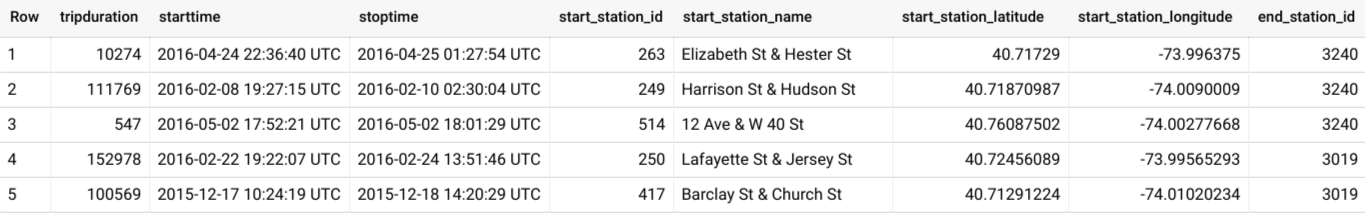

In [ ]:
# Create empty dataframe
citibike_data = pd.DataFrame()

# For each file: load the contents into a dataframe
# and concatenate the new dataframe with the existing
for blob in blobs:
    print("blob" + str(blob.name))
    filename = f'gs://{BUCKET_NAME}/{blob.name}'
    new_df = pd.read_csv(filename, compression='gzip', usecols=[1, 2, 3, 7], header=None,
                         names=COLUMNS, low_memory=False)
    citibike_data = pd.concat([citibike_data, new_df])

citibike_data.head(10)

## Extract features

### Reformat the data
The following cell will modify the dataset in a few ways:

+ Any rows with NaN values will be dropped
+ The station IDs will be converted from floats to integers
+ The times from the start time column will be removed since they are not needed

In [ ]:
# Drop rows with NaN values
citibike_data = citibike_data.dropna()

# Convert station IDs to integers
citibike_data['start_station_id'] = citibike_data['start_station_id'].astype('int32')
citibike_data['end_station_id'] = citibike_data['end_station_id'].astype('int32')

# Remove time from the time columns
citibike_data['starttime'] = citibike_data['starttime'].apply(lambda t: t.split("T")[0])
citibike_data['stoptime'] = citibike_data['stoptime'].apply(lambda t: t.split("T")[0])

citibike_data.head(10)

### Count trips starting from a station

Next, count the number of trips that have been started from each station per day. The `groupby` function from Pandas will count the number of unique combinations of the start time and start station ID values. Then, the `pivot` function from Pandas can be used to convert the station IDs into columns (since they are the target data) and the counts as the values.

Also, use the `add_prefix` function to rename the columns and distinguish that the values indicate trips that have started from the station.

In [ ]:
# Find unique combinations of start time and start station ID values
trips_started = (citibike_data.groupby(['starttime', 'start_station_id'])
                              .size().reset_index().rename(columns={0: 'count'}))

# Pivot to make station ID the columns and rename them
trips_started = (trips_started.pivot(index='starttime', columns='start_station_id', values='count')
                              .add_prefix('started_at_'))
trips_started.head(10)

### Count trips ending at a station

Running the following cell will repeat the same process as above, but will generate values for the number of trips that have ended at the station.

In [ ]:
# Find unique combinations of stop time and end station ID values
trips_ended = (citibike_data.groupby(['stoptime', 'end_station_id'])
                            .size().reset_index().rename(columns={0: 'count'}))

# Pivot to make station ID the columns and rename them
trips_ended = (trips_ended.pivot(index='stoptime', columns='end_station_id', values='count')
                          .add_prefix('ending_at_'))

trips_ended.head(10)

## Putting it together

The following cell will combine both dataframes for trips started and ended at the stations. Then, all NaN values will be replaced with a 0 since this indicates that no trips started or ended at that particular station. Lastly, the dataset will be cleaned up by renaming the columns and converting the values to integers.

In [ ]:
# Combine the dataframes
# Set the index as row number instead of start time
# Fill the NaN values with 0's
citibike_df = (pd.concat([trips_started, trips_ended], axis=1)
               .reset_index()
               .fillna(0))

# Rename the column with start and end dates
citibike_df.rename(columns={'index': 'date'}, inplace=True)

# Convert all values to integers
for col in citibike_df.columns:
    if col == 'date':
        continue
    citibike_df[col] = citibike_df[col].astype(int)

citibike_df.head(10)

You are done with feature engineering for the Citibike Dataset! Now, you can move on to the external datasets you ingested in BigQuery to obtain more features, starting with **Gas Prices**.

# Gas Prices Dataset

Now, perform feature engineering on the [Gas Prices dataset](https://data.ny.gov/Energy-Environment/Gasoline-Prices/wuxr-ni2i). This includes cleaning the data, normalizing the price values, and transforming the data to match the Citibike dataset.

## Load the data

### Import libraries
Running the following cell will import the libraries needed to preprocess the external datasets.

+ **Datetime**: to manipulate the date column
+ **BigQuery**: to retrieve the datasets from BigQuery
+ **scikit-learn**: to normalize the numerical column values

In [ ]:
import datetime

from google.cloud import bigquery
from sklearn import preprocessing

### Load the data from BigQuery into a dataframe

Run the following cell to load the Gas Prices dataset from BigQuery into a dataframe. You will define a query that selects the columns needed from the gas prices dataset, run the query using the BigQuery client, and then convert it to a Pandas DataFrame.

If you named your dataset something other than `new_york_citibike_trips`, be sure to update the `DATASET_NAME` variable.


In [ ]:
LOCATION = 'US'
DATASET_NAME = 'new_york_citibike_trips'

# Create the BigQuery client
bigquery_client = bigquery.Client(location=LOCATION)

# Define the query
table = f'{PROJECT_ID}.{DATASET_NAME}.gas_prices'
query = f' SELECT Date as date, New_York_City_Average_USD_per_Gal as nyc_gas_price FROM {table}'

# Run the query
query_job = bigquery_client.query(
    query,
    location=LOCATION
)

# Convert to a dataframe
gas_df = query_job.to_dataframe()

gas_df.head(10)

## Normalize values

The gas price values range from around 2 USD to 5 USD. It is important to normalize these values and scale them to be between 0 and 1 so that all the values within our dataset are weighted consistently. Running the following cell will create a scaler using the MinMaxScaler from scikit-learn and then fit the gas prices to the scaler.

In [ ]:
# Extract gas prices column as a numpy array
gas_values = gas_df[['nyc_gas_price']].values

# Create scaler from sklearn
min_max_scaler = preprocessing.MinMaxScaler()

# Fit values to the scaler and replace column with normalized values
gas_values_scaled = min_max_scaler.fit_transform(gas_values)
gas_df['nyc_gas_price'] = gas_values_scaled

gas_df.head(10)

## Copy prices for the week

The Citibike dataset contains pricing values for each day, however, the Gas Prices dataset contains one value per week. To get daily pricing values, you can assign a week's pricing value to each day of that particular week.

First, run the following cell to refactor the date so it matches the format of a datetime object.

In [ ]:
def refactor_date(date):
    '''Refactor the date strings so they match the Citibike dataset'''
    parts = date.split('/')
    return f'{parts[2]}-{parts[0]}-{parts[1]}'


gas_df['date'] = gas_df['date'].apply(lambda d: refactor_date(d))
gas_df.head(10)

Now, copy the gas price of one day for the whole week by adding new rows to the dataframe.

The following cell does this by applying a function to each row in the dataframe that:
+ Converts each date to a datetime object
+ Loops through the next six days to create new rows
+ Appends the new rows to a list

In [ ]:
# Define list to hold new rows
new_rows = []


def copy_values_for_week(row):
    '''Copies gas price of one day for the entire week '''
    today = datetime.datetime.strptime(row['date'], '%Y-%m-%d')
    # Loop through the next six days
    for day in range(1, 7):
        # Create and a new row for the next day
        new_day = datetime.datetime.strftime(today + datetime.timedelta(days=day), '%Y-%m-%d')
        new_row = {'date': new_day, 'nyc_gas_price': row['nyc_gas_price']}
        new_rows.append(new_row)


# Apply copy function to dataframe
gas_df.apply(copy_values_for_week, axis=1)

# Add new rows to dataframe
gas_df = gas_df.append(new_rows)

gas_df

You have now finished transforming the Gas Prices dataset! Now you can move on to the next external dataset: **US Holidays**.

# US Holidays Dataset

## Load the data

Run the following cell to load the [US Holidays dataset](https://github.com/GoogleCloudPlatform/python-docs-samples/blob/main/data-science-onramp/data-ingestion/holidays.csv) from BigQuery into a dataframe. Similarly to loading the Gas Prices dataset, this query selects the columns needed, runs the query using the BigQuery client, and converts the job to a dataframe.

In [ ]:
# Define the query
table = f'{PROJECT_ID}.{DATASET_NAME}.usholidays'
query = f' SELECT Date as date, Holiday as holiday FROM {table}'

# Run the query
query_job = bigquery_client.query(
    query,
    location=LOCATION,
)

# Convert to a dataframe
holiday_df = query_job.to_dataframe()

holiday_df

## Transform the holiday column

The purpose of the holiday feature column is to represent a binary value for whether there is a holiday on a specific day or not, rather than the type of holiday. Since this dataset contains only days with holidays, run the following cell to convert the holiday values to 1 (referring to `True`). Later, when combining the datasets, you will add values of 0 (referring to `False`) to dates that are present in the other datasets but not this one.

In [ ]:
holiday_df['holiday'] = holiday_df['holiday'].apply(lambda h: 1)
holiday_df.head(10)

You have now finished transforming the US Holidays dataset! Now you can move on to the next external dataset: **Weather**.

# Weather Dataset

## Load the data

Run the following cell to load the [Weather dataset](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ghcn_d&page=dataset) from BigQuery into a dataframe. For each year needed, you will:

+ Define a query that selects the required columns (whether there was impactful weather that day, precipitation (mm), minimum temperature, maximum temperature)
+ Run the query using the BigQuery client
+ Convert the job to a dataframe
+ Concatenate it with the combined dataframe

In [ ]:
# Initialize combined weather dataframe
weather_df = pd.DataFrame()

years = ['2013', '2014', '2015', '2016', '2017', '2018']
for year in years:
    # Define a query
    query = f''' SELECT
              date,
              IF(MAX(haswx) = 'True', 'True', 'False') AS impactful,
              MAX(prcp) AS prcp,
              MAX(tmin) AS min_temp,
              MAX(tmax) AS max_temp
             FROM (
              SELECT
                wx.date,
                IF (SUBSTR(wx.element, 0, 2) = 'WT', 'True', NULL) AS haswx,
                IF (wx.element = 'PRCP', wx.value/10, NULL) AS prcp,
                IF (wx.element = 'TMIN', wx.value/10, NULL) AS tmin,
                IF (wx.element = 'TMAX', wx.value/10, NULL) AS tmax
              FROM
                `bigquery-public-data.ghcn_d.ghcnd_{year}` AS wx
              WHERE
                id = 'USW00094728')
             GROUP BY
              date
             ORDER BY
              date'''

    # Run the query
    query_job = bigquery_client.query(
        query,
        location=LOCATION
    )

    # Convert to a dataframe
    curr_df = query_job.to_dataframe()

    # Concatenate with combined dataframe
    weather_df = pd.concat([weather_df, curr_df])

weather_df.head(10)

## Normalize Values

Similarly to the gas price values, the precipitation and temperature values must be normalized so all the values within the dataset are weighted consistently.

In [ ]:
cols_to_normalize = ['prcp', 'min_temp', 'max_temp']

for col_name in cols_to_normalize:
    # Extract values
    temp_values = weather_df[[col_name]].values

    # Fit values to the scaler and replace column with normalized values
    temp_values_scaled = min_max_scaler.fit_transform(temp_values)
    weather_df[col_name] = temp_values_scaled

weather_df.head(10)

## Convert column data types

### Date column

Run the following cell to change the datatype of the date column from a Datetime object to a string, so that it can be properly combined with the other datasets.

In [ ]:
weather_df['date'] = weather_df['date'].apply(lambda d: datetime.datetime.strftime(d, '%Y-%m-%d'))
weather_df.head(10)

### Impactful column

Run the following cell to encode the `True` and `False` column values to 0 or 1 so that they can be correctly interpreted by the machine learning model.

In [ ]:
weather_df['impactful'] = weather_df['impactful'].apply(lambda impact: 1 if impact == "True" else 0)
weather_df.head(10)

# Combine the datasets

Now that all of the datasets have been transformed, combine them to create one table. The Pandas [`merge`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) function can only combine two datasets at a time, so each dataset will be merged separetely.

+ **Citibike Trips** and **Gas Prices**: merge on the date column by specifying `on="date"` to create a *combined dataframe*
+ *Combined dataframe* and **US Holidays**: merge both datasets on the date column, keep the dates of the combined dataframe by specifying `how='right'`, and fill the empty rows with `False`
+ *Combined dataframe* and **Weather**: merge on the date column by specifying `on="date"` to create the *final dataframe*

In [ ]:
# Merge both gas dataset with citibike dataset
final_df = pd.merge(gas_df, citibike_df, on="date")

# Merge combined dataset with holiday dataset
final_df = pd.merge(holiday_df, final_df, how="right", on="date").fillna(0)

# Merge combined dataset with weather dataset
final_df = pd.merge(weather_df, final_df, on="date")

final_df

# Improve the date feature

Now that all the datasets have been combined, you can separate the date column into more features such as the year, month, and day. Then, the date column can be dropped.

In [ ]:
# Define the name and year, month, and day columns
date_columns = final_df['date'].str.split('-', expand=True)
date_names = ['year', 'month', 'day']

# Add the columns at the start of the dataset
for i in range(3):
    final_df.insert(0, date_names[i], date_columns[i])
    final_df[date_names[i]] = final_df[date_names[i]].astype('int32')

# Remove the date column from the dataframe
final_df = final_df.drop('date', axis=1)

final_df.head(10)

The following cell will extract the day of the week from the date information using the Datetime python library.

In [ ]:
def find_weekday(df):
    ''' Creates a datetime object and returns the day of the week '''
    date = datetime.datetime(int(df['year']), int(df['month']), int(df['day']))
    return date.weekday()


# Apply the find_weekday() function to every row of the dataset
weekday_col = final_df.apply(find_weekday, axis=1)

# Insert the weekday column at the start
final_df.insert(0, 'weekday', weekday_col)

final_df

# Upload the data to a GCS bucket

Now that you have finished feature engineering on all of the datasets, you will need to upload the data to a bucket so that it can be accessed later when training a model. Run the following cell to upload the final dataframe to the GCS bucket you specified earlier.

In [ ]:
# Get bucket using storage client
bucket = storage_client.get_bucket(BUCKET_NAME)

# Upload the final dataframe as a csv file to the bucket
bucket.blob('feature_engineering/final_data.csv').upload_from_string(final_df.to_csv(), 'text/csv')

You have now finished feature engineering on all of the datasets! Model training is next.

In [ ]:
###################################################################
###USED FOR INTERNAL TESTING TEARDOWN - USERS MAY SKIP THIS CELL###
###################################################################


def delete_blob_in_gcs(blob_name):
    '''Delete a blob in GCS'''
    blob = bucket.blob(blob_name)
    blob.delete()


# Delete blob from GCS
delete_blob_in_gcs('clean_data/citibike.csv.gz')
delete_blob_in_gcs('holidays.csv')
delete_blob_in_gcs('gasprices.csv')


# Delete dataset from BigQuery

bigquery_client.delete_dataset(
    f'{PROJECT_ID}.{DATASET_NAME}', delete_contents=True, not_found_ok=True
)